# Shot Selection Analysis: High-Value Zone Usage

This notebook analyzes **shot selection quality** - not who has the best PPS, but **who is shooting from the right places**.

## Key Concept: High-Value Zones

Based on league-wide PPS data, some zones generate significantly more expected points per shot:

| Zone | League PPS | Value |
|------|-----------|-------|
| Restricted Area | ~1.33 | HIGH |
| Corner 3s | ~1.15 | HIGH |
| Above the Break 3 | ~1.05 | HIGH |
| In The Paint (Non-RA) | ~0.89 | LOW |
| Mid-Range | ~0.83 | LOWEST |

**Smart teams maximize shots from high-value zones and minimize low-value shots.**

## Analysis Overview
1. Zone Value Benchmarks
2. Team Shot Selection Rankings
3. Bulls Shot Distribution Analysis
4. Validation: Does Shot Selection Win Games?
5. Player-Level Shot Selection
6. Summary & Recommendations

In [1]:
# Setup - Import libraries and configure
import sys
from pathlib import Path

# Add parent directory to path so we can import bulls
sys.path.insert(0, str(Path().absolute().parent))

from bulls import data, analysis, viz
from bulls.config import CURRENT_SEASON, BULLS_TEAM_ID
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Configure matplotlib for better display in notebooks
plt.style.use('default')
%matplotlib inline

print("Bulls Analytics loaded")
print(f"Season: {CURRENT_SEASON}")

Bulls Analytics loaded
Season: 2025-26


---

## Section 1: Zone Value Benchmarks

First, let's establish which zones are high-value vs low-value based on league-wide PPS data.

In [2]:
# Fetch league-wide shot data
import time as _time
start_time = _time.time()

print(f"Fetching shot data for all 30 NBA teams ({CURRENT_SEASON})...")
print("This may take several minutes due to API rate limits.")
print("=" * 60)

league_shots = data.get_league_shots(season=CURRENT_SEASON)

elapsed = _time.time() - start_time
print(f"\n Complete! Fetched {len(league_shots):,} total shots in {elapsed/60:.1f} minutes")
print(f"  Teams: {league_shots['team_abbr'].nunique()}")

Fetching shot data for all 30 NBA teams (2025-26)...
This may take several minutes due to API rate limits.
[1/30] Fetching Atlanta Hawks...
    -> 4,107 shots
[2/30] Fetching Boston Celtics...
    -> 3,817 shots
[3/30] Fetching Brooklyn Nets...
    -> 3,498 shots
[4/30] Fetching Charlotte Hornets...
    -> 3,839 shots
[5/30] Fetching Chicago Bulls...
    -> 3,815 shots
[6/30] Fetching Cleveland Cavaliers...
    -> 4,051 shots
[7/30] Fetching Dallas Mavericks...
    -> 3,927 shots
[8/30] Fetching Denver Nuggets...
    -> 3,749 shots
[9/30] Fetching Detroit Pistons...
    -> 3,679 shots
[10/30] Fetching Golden State Warriors...
    -> 3,909 shots
[11/30] Fetching Houston Rockets...
    -> 3,631 shots
[12/30] Fetching Indiana Pacers...
    -> 3,930 shots
[13/30] Fetching LA Clippers...
    -> 3,474 shots
[14/30] Fetching Los Angeles Lakers...
    -> 3,434 shots
[15/30] Fetching Memphis Grizzlies...
    -> 3,734 shots
[16/30] Fetching Miami Heat...
    -> 4,019 shots
[17/30] Fetching Milwa

In [3]:
# Calculate league-wide PPS by zone
league_pps = analysis.league_pps_by_zone(league_shots)

# Get zone rankings
zone_rankings = analysis.zone_value_ranking(league_pps)

# Define high-value zones based on PPS
HIGH_VALUE_ZONES = ['Restricted Area', 'Right Corner 3', 'Left Corner 3', 'Above the Break 3']
LOW_VALUE_ZONES = ['In The Paint (Non-RA)', 'Mid-Range']

print("=== Zone Value Rankings (League-Wide PPS) ===")
print()
for _, row in zone_rankings.iterrows():
    zone = row['Zone']
    value_label = 'HIGH VALUE' if zone in HIGH_VALUE_ZONES else 'LOW VALUE'
    print(f"  {row['Rank']}. {zone:<25} {row['PPS']:.3f} PPS ({row['Volume%']:.1f}% of shots) - {value_label}")

print(f"\n League Overall PPS: {league_pps['league_overall']['pps']:.3f}")

=== Zone Value Rankings (League-Wide PPS) ===

  1. Restricted Area           1.335 PPS (28.2% of shots) - HIGH VALUE
  2. Right Corner 3            1.150 PPS (5.2% of shots) - HIGH VALUE
  3. Left Corner 3             1.142 PPS (5.5% of shots) - HIGH VALUE
  4. Above the Break 3         1.053 PPS (30.8% of shots) - HIGH VALUE
  5. In The Paint (Non-RA)     0.894 PPS (20.3% of shots) - LOW VALUE
  6. Mid-Range                 0.833 PPS (10.1% of shots) - LOW VALUE

 League Overall PPS: 1.088


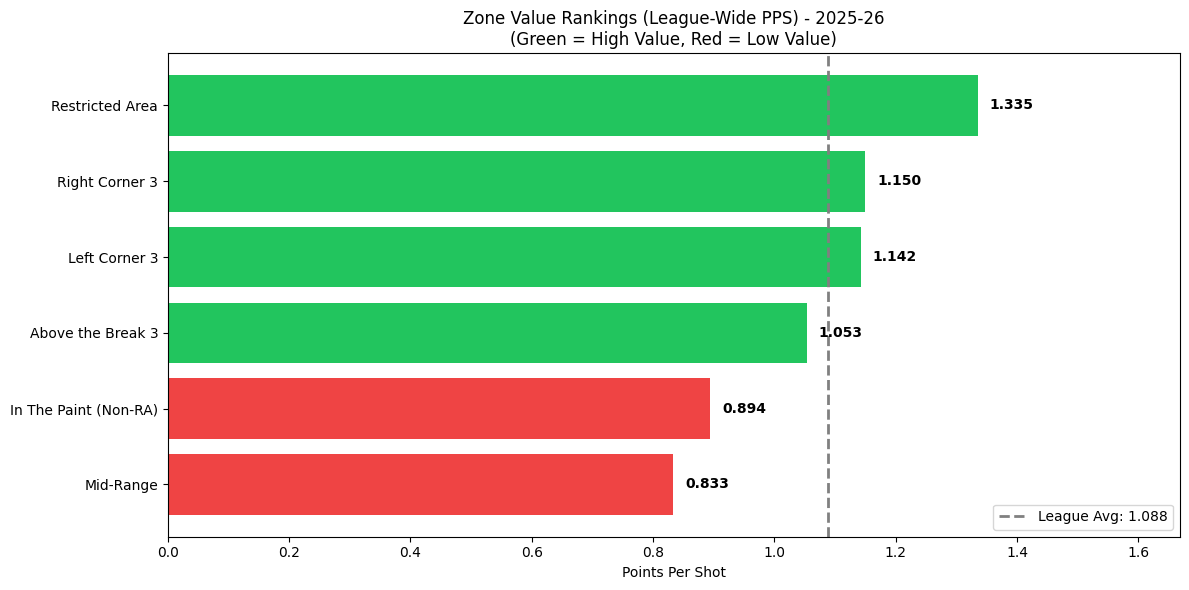


 Key Insight: Teams should maximize shots from green (high-value) zones.


In [4]:
# Visualize zone value rankings
fig, ax = plt.subplots(figsize=(12, 6))

# Sort by PPS
zone_plot = zone_rankings.sort_values('PPS', ascending=True)

# Color by high-value vs low-value
colors = ['#22c55e' if zone in HIGH_VALUE_ZONES else '#ef4444' for zone in zone_plot['Zone']]

bars = ax.barh(zone_plot['Zone'], zone_plot['PPS'], color=colors)

# Add league average line
league_avg_pps = league_pps['league_overall']['pps']
ax.axvline(x=league_avg_pps, color='gray', linestyle='--', 
           linewidth=2, label=f"League Avg: {league_avg_pps:.3f}")

# Add value labels
for bar, row in zip(bars, zone_plot.itertuples()):
    ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
            f"{row.PPS:.3f}",
            va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Points Per Shot')
ax.set_title(f'Zone Value Rankings (League-Wide PPS) - {CURRENT_SEASON}\n(Green = High Value, Red = Low Value)')
ax.legend(loc='lower right')
ax.set_xlim(0, max(zone_plot['PPS']) * 1.25)

plt.tight_layout()
plt.show()

print("\n Key Insight: Teams should maximize shots from green (high-value) zones.")

---

## Section 2: Team Shot Selection Rankings

Now let's rank all 30 teams by what percentage of their shots come from high-value zones. This measures **shot selection quality**, not shooting ability.

In [5]:
# Calculate high-value zone usage for all teams
usage_rankings = analysis.high_value_zone_usage(league_shots)

# Find Bulls position
bulls_usage = usage_rankings[usage_rankings['team_abbr'] == 'CHI'].iloc[0]
league_avg_high_value = usage_rankings['high_value_pct'].mean()

print("=== Team Shot Selection Rankings ===")
print("(Ranked by % of shots from high-value zones)\n")

print(f"{'Rank':<6} {'Team':<6} {'High Value %':>12} {'Restricted %':>14} {'3PT %':>10}")
print("-" * 55)

for _, row in usage_rankings.head(10).iterrows():
    marker = ' ***' if row['team_abbr'] == 'CHI' else ''
    print(f"{int(row['rank']):<6} {row['team_abbr']:<6} {row['high_value_pct']:>11.1f}% {row['restricted_area_pct']:>13.1f}% {row['three_point_pct']:>9.1f}%{marker}")

if bulls_usage['rank'] > 10:
    print("...")
    print(f"{int(bulls_usage['rank']):<6} {'CHI':<6} {bulls_usage['high_value_pct']:>11.1f}% {bulls_usage['restricted_area_pct']:>13.1f}% {bulls_usage['three_point_pct']:>9.1f}% ***")

print(f"\n League Average High-Value %: {league_avg_high_value:.1f}%")
print(f" Bulls High-Value %: {bulls_usage['high_value_pct']:.1f}% (Rank #{int(bulls_usage['rank'])})")
print(f" Difference: {bulls_usage['high_value_pct'] - league_avg_high_value:+.1f}%")

=== Team Shot Selection Rankings ===
(Ranked by % of shots from high-value zones)

Rank   Team   High Value %   Restricted %      3PT %
-------------------------------------------------------
1      CHI           78.7%          35.6%      43.2% ***
2      POR           77.5%          31.5%      46.0%
3      BKN           75.4%          27.5%      47.9%
4      GSW           75.0%          24.9%      50.1%
5      CHA           74.4%          28.3%      46.0%
6      NOP           74.2%          39.5%      34.7%
7      CLE           73.7%          28.3%      45.4%
8      PHI           73.4%          32.9%      40.5%
9      SAS           73.0%          31.1%      41.9%
10     MIN           72.3%          29.9%      42.4%

 League Average High-Value %: 69.6%
 Bulls High-Value %: 78.7% (Rank #1)
 Difference: +9.1%


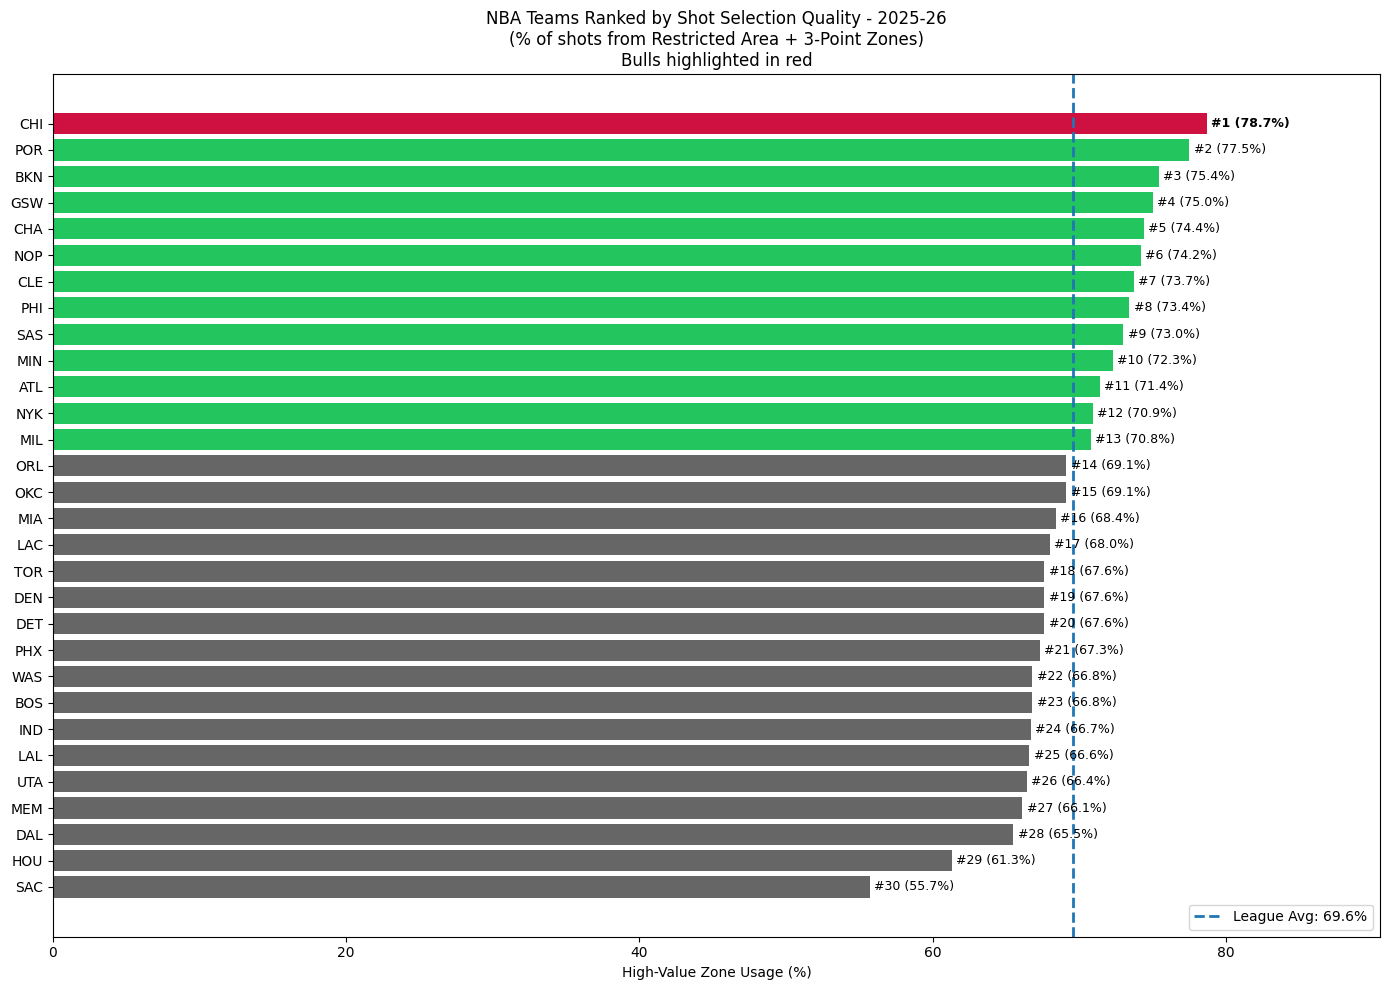

In [6]:
# Bar chart: All teams ranked by high-value zone usage
fig, ax = plt.subplots(figsize=(14, 10))

# Sort by high-value % ascending for horizontal bar chart
teams_sorted = usage_rankings.sort_values('high_value_pct', ascending=True)

# Color Bulls red, others by tier
colors = []
for _, row in teams_sorted.iterrows():
    if row['team_abbr'] == 'CHI':
        colors.append('#CE1141')  # Bulls red
    elif row['high_value_pct'] >= league_avg_high_value:
        colors.append('#22c55e')  # Above average - green
    else:
        colors.append('#666666')  # Below average - gray

bars = ax.barh(teams_sorted['team_abbr'], teams_sorted['high_value_pct'], color=colors)

# Add league average line
ax.axvline(x=league_avg_high_value, color='#1f77b4', linestyle='--', 
           linewidth=2, label=f"League Avg: {league_avg_high_value:.1f}%")

# Add rank labels
for i, (bar, row) in enumerate(zip(bars, teams_sorted.itertuples())):
    rank = 30 - i
    fontweight = 'bold' if row.team_abbr == 'CHI' else 'normal'
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
            f"#{rank} ({row.high_value_pct:.1f}%)",
            va='center', fontsize=9, fontweight=fontweight)

ax.set_xlabel('High-Value Zone Usage (%)')
ax.set_title(f'NBA Teams Ranked by Shot Selection Quality - {CURRENT_SEASON}\n(% of shots from Restricted Area + 3-Point Zones)\nBulls highlighted in red')
ax.legend(loc='lower right')
ax.set_xlim(0, max(teams_sorted['high_value_pct']) * 1.15)

plt.tight_layout()
plt.show()

---

## Section 3: Bulls Shot Distribution Analysis

Compare the Bulls' shot distribution to the top 5 teams in high-value usage. Where should the Bulls shoot more or less?

In [7]:
# Get Bulls shot distribution
bulls_team_data = league_pps['by_team']['CHI']
bulls_zones = bulls_team_data['by_zone']
bulls_total_shots = sum(z.get('total_shots', 0) for z in bulls_zones.values())

# Get top 5 teams in high-value usage
top_5_teams = usage_rankings.head(5)['team_abbr'].tolist()

# Calculate average shot distribution of top 5 teams
zones = list(league_pps['by_zone'].keys())
top5_distribution = {}
for zone in zones:
    zone_pcts = []
    for team in top_5_teams:
        team_zones = league_pps['by_team'][team]['by_zone']
        team_total = sum(z.get('total_shots', 0) for z in team_zones.values())
        if team_total > 0 and zone in team_zones:
            zone_pcts.append(team_zones[zone]['total_shots'] / team_total * 100)
    if zone_pcts:
        top5_distribution[zone] = np.mean(zone_pcts)

# Bulls distribution
bulls_distribution = {}
for zone in zones:
    if zone in bulls_zones:
        bulls_distribution[zone] = bulls_zones[zone]['total_shots'] / bulls_total_shots * 100
    else:
        bulls_distribution[zone] = 0

# Compare
print("=== Bulls vs Top 5 Teams Shot Distribution ===")
print(f"Top 5 Teams: {', '.join(top_5_teams)}\n")

print(f"{'Zone':<25} {'Bulls %':>10} {'Top 5 Avg %':>12} {'Gap':>10} {'Action':>15}")
print("-" * 75)

total_high_value_bulls = 0
total_high_value_top5 = 0

for zone in zones:
    bulls_pct = bulls_distribution.get(zone, 0)
    top5_pct = top5_distribution.get(zone, 0)
    gap = bulls_pct - top5_pct
    
    if zone in HIGH_VALUE_ZONES:
        total_high_value_bulls += bulls_pct
        total_high_value_top5 += top5_pct
        action = 'INCREASE' if gap < -2 else 'Good' if gap >= -2 else ''
    else:
        action = 'DECREASE' if gap > 2 else 'Good' if gap <= 2 else ''
    
    value_marker = '' if zone in HIGH_VALUE_ZONES else '(low value)'
    print(f"{zone:<25} {bulls_pct:>9.1f}% {top5_pct:>11.1f}% {gap:>+9.1f}% {action:>15} {value_marker}")

print("-" * 75)
print(f"{'HIGH-VALUE TOTAL':<25} {total_high_value_bulls:>9.1f}% {total_high_value_top5:>11.1f}% {total_high_value_bulls - total_high_value_top5:>+9.1f}%")

=== Bulls vs Top 5 Teams Shot Distribution ===
Top 5 Teams: CHI, POR, BKN, GSW, CHA

Zone                         Bulls %  Top 5 Avg %        Gap          Action
---------------------------------------------------------------------------
Above the Break 3              31.3%        34.9%      -3.6%        INCREASE 
Restricted Area                35.6%        29.6%      +6.0%            Good 
Right Corner 3                  5.6%         5.8%      -0.2%            Good 
In The Paint (Non-RA)          16.7%        16.9%      -0.2%            Good (low value)
Left Corner 3                   6.2%         5.9%      +0.3%            Good 
Mid-Range                       4.5%         6.9%      -2.4%            Good (low value)
---------------------------------------------------------------------------
HIGH-VALUE TOTAL               78.7%        76.2%      +2.5%


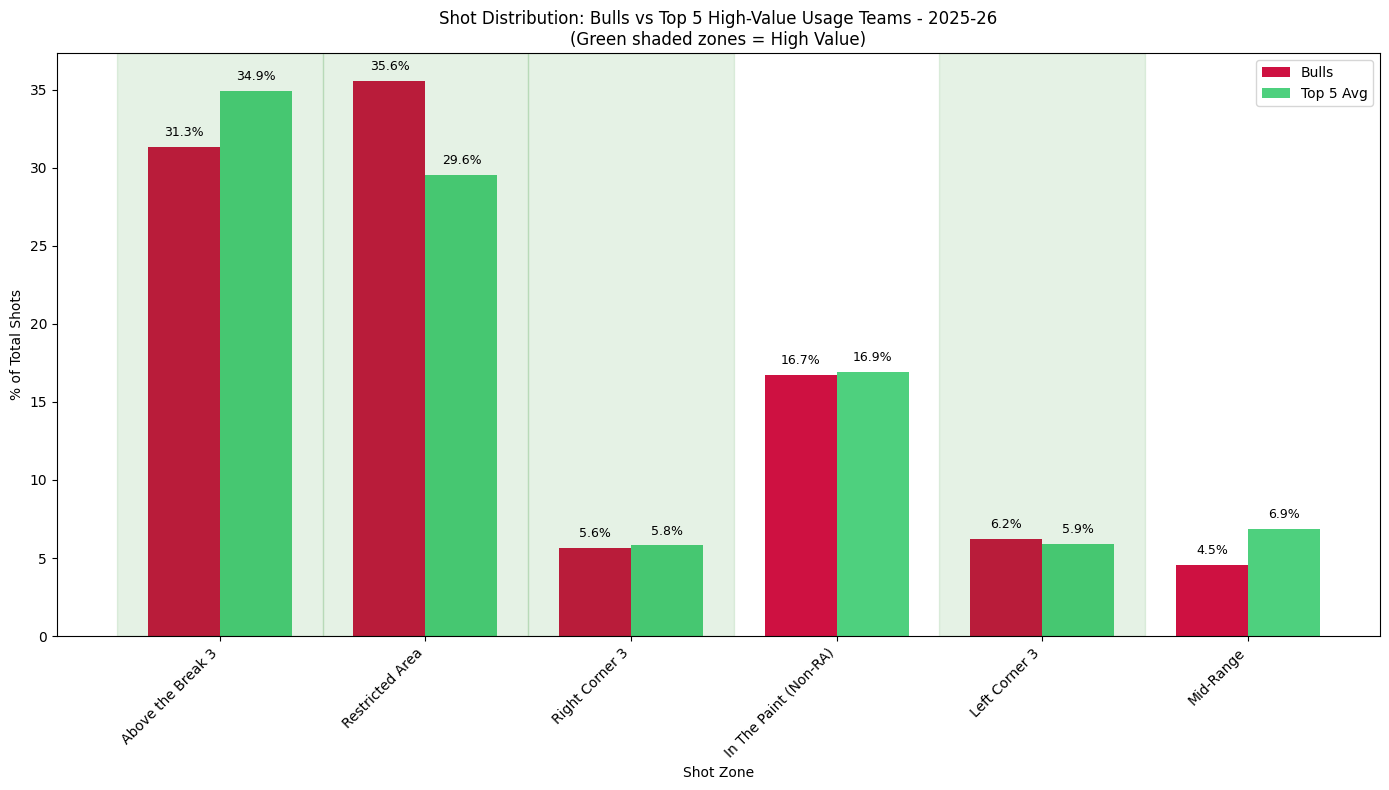

In [8]:
# Grouped bar chart: Bulls vs Top 5 shot distribution
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(zones))
width = 0.35

bulls_pcts = [bulls_distribution.get(z, 0) for z in zones]
top5_pcts = [top5_distribution.get(z, 0) for z in zones]

bars1 = ax.bar(x - width/2, bulls_pcts, width, label='Bulls', color='#CE1141')
bars2 = ax.bar(x + width/2, top5_pcts, width, label=f'Top 5 Avg', color='#22c55e', alpha=0.8)

# Add value labels
for bar, pct in zip(bars1, bulls_pcts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)
for bar, pct in zip(bars2, top5_pcts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

# Highlight high-value zones
for i, zone in enumerate(zones):
    if zone in HIGH_VALUE_ZONES:
        ax.axvspan(i - 0.5, i + 0.5, alpha=0.1, color='green')

ax.set_ylabel('% of Total Shots')
ax.set_xlabel('Shot Zone')
ax.set_title(f'Shot Distribution: Bulls vs Top 5 High-Value Usage Teams - {CURRENT_SEASON}\n(Green shaded zones = High Value)')
ax.set_xticks(x)
ax.set_xticklabels(zones, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

---

## Section 4: Validation - Does Shot Selection Win Games?

Is there a correlation between high-value zone usage and winning? Let's check if smart shot selection actually matters.

In [9]:
# Fetch team standings/records for correlation analysis
# We'll use overall PPS as a proxy for success initially
# (since shooting efficiency correlates strongly with winning)

# Merge high-value usage with overall PPS
team_comparison = analysis.team_zone_comparison(league_pps)
merged_data = usage_rankings.merge(
    team_comparison[['Team', 'Overall']], 
    left_on='team_abbr', 
    right_on='Team'
)

# Calculate correlation
correlation = merged_data['high_value_pct'].corr(merged_data['Overall'])

print("=== Shot Selection vs Efficiency Correlation ===")
print(f"\nCorrelation between High-Value Zone Usage and Overall PPS: {correlation:.3f}")
print(f"\nInterpretation:")
if correlation > 0.5:
    print("  STRONG POSITIVE: Teams that shoot from high-value zones tend to be more efficient.")
elif correlation > 0.3:
    print("  MODERATE POSITIVE: Shot selection has a meaningful impact on efficiency.")
elif correlation > 0:
    print("  WEAK POSITIVE: Shot selection has some impact on efficiency.")
else:
    print("  NO CLEAR RELATIONSHIP: Other factors dominate efficiency.")

=== Shot Selection vs Efficiency Correlation ===

Correlation between High-Value Zone Usage and Overall PPS: 0.130

Interpretation:
  WEAK POSITIVE: Shot selection has some impact on efficiency.


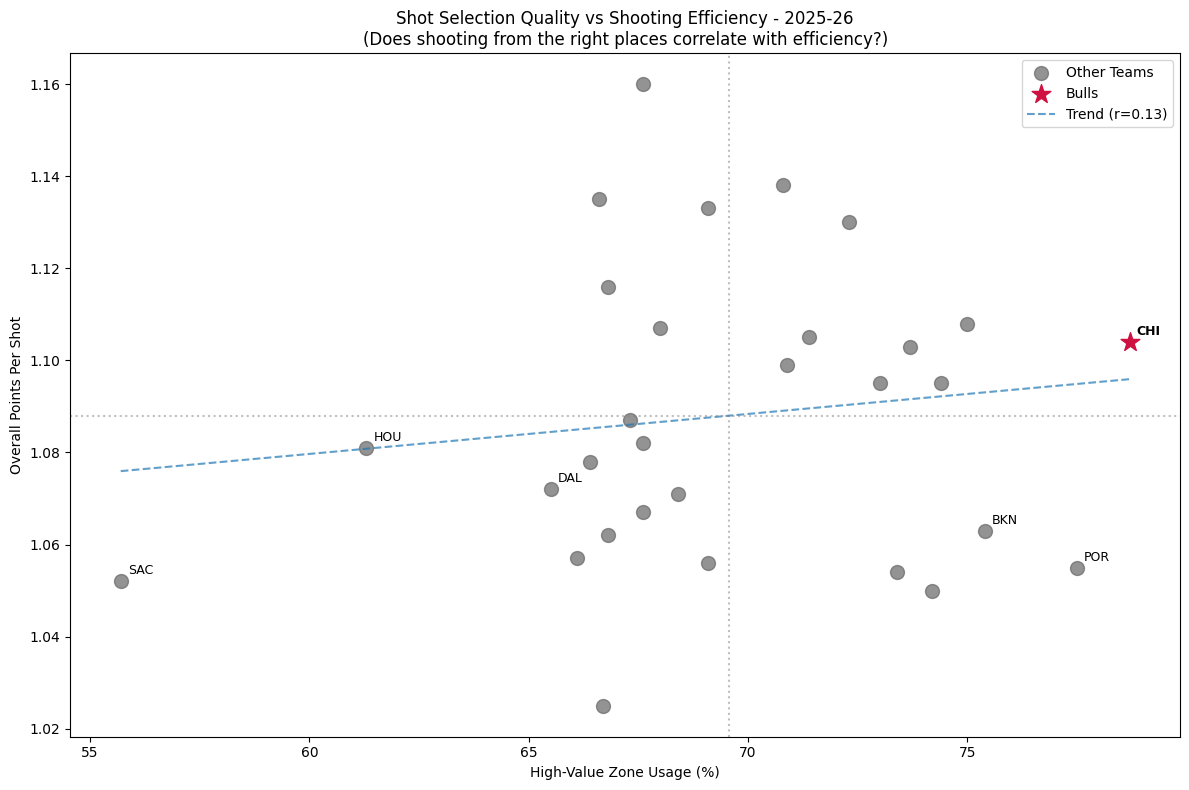


 Bulls Position: Top Right (Good selection + Good efficiency)


In [10]:
# Scatter plot: High-Value Zone Usage vs Overall PPS
fig, ax = plt.subplots(figsize=(12, 8))

# Plot all teams
non_bulls = merged_data[merged_data['team_abbr'] != 'CHI']
bulls = merged_data[merged_data['team_abbr'] == 'CHI']

ax.scatter(non_bulls['high_value_pct'], non_bulls['Overall'], 
           c='#666666', s=100, alpha=0.7, label='Other Teams')

# Highlight Bulls
ax.scatter(bulls['high_value_pct'], bulls['Overall'], 
           c='#CE1141', s=200, marker='*', zorder=5, label='Bulls')

# Add team labels for top/bottom teams and Bulls
for _, row in merged_data.iterrows():
    if row['team_abbr'] in ['CHI'] + list(merged_data.nlargest(3, 'high_value_pct')['team_abbr']) + list(merged_data.nsmallest(3, 'high_value_pct')['team_abbr']):
        fontweight = 'bold' if row['team_abbr'] == 'CHI' else 'normal'
        ax.annotate(row['team_abbr'], (row['high_value_pct'], row['Overall']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9, fontweight=fontweight)

# Add trend line
z = np.polyfit(merged_data['high_value_pct'], merged_data['Overall'], 1)
p = np.poly1d(z)
x_line = np.linspace(merged_data['high_value_pct'].min(), merged_data['high_value_pct'].max(), 100)
ax.plot(x_line, p(x_line), '--', color='#1f77b4', alpha=0.7, label=f'Trend (r={correlation:.2f})')

# Add quadrant lines at league averages
ax.axhline(y=merged_data['Overall'].mean(), color='gray', linestyle=':', alpha=0.5)
ax.axvline(x=merged_data['high_value_pct'].mean(), color='gray', linestyle=':', alpha=0.5)

ax.set_xlabel('High-Value Zone Usage (%)')
ax.set_ylabel('Overall Points Per Shot')
ax.set_title(f'Shot Selection Quality vs Shooting Efficiency - {CURRENT_SEASON}\n(Does shooting from the right places correlate with efficiency?)')
ax.legend()

plt.tight_layout()
plt.show()

# Quadrant analysis
avg_usage = merged_data['high_value_pct'].mean()
avg_pps = merged_data['Overall'].mean()

bulls_quadrant = ''
if bulls['high_value_pct'].values[0] >= avg_usage and bulls['Overall'].values[0] >= avg_pps:
    bulls_quadrant = 'Top Right (Good selection + Good efficiency)'
elif bulls['high_value_pct'].values[0] >= avg_usage and bulls['Overall'].values[0] < avg_pps:
    bulls_quadrant = 'Bottom Right (Good selection, needs to convert better)'
elif bulls['high_value_pct'].values[0] < avg_usage and bulls['Overall'].values[0] >= avg_pps:
    bulls_quadrant = 'Top Left (Poor selection, but efficient - room to improve selection)'
else:
    bulls_quadrant = 'Bottom Left (Poor selection + Poor efficiency)'

print(f"\n Bulls Position: {bulls_quadrant}")

---

## Section 5: Player-Level Shot Selection

Which Bulls players are making the smartest shot selection choices? Who's taking too many low-value shots?

In [11]:
# Get Bulls player shot data
bulls_shots = league_shots[league_shots['team_abbr'] == 'CHI'].copy()

# Calculate per-player high-value zone usage
MIN_SHOTS = 50  # Minimum shots to qualify

player_selection = []

for player_name in bulls_shots['player_name'].unique():
    player_shots = bulls_shots[bulls_shots['player_name'] == player_name]
    total_shots = len(player_shots)
    
    if total_shots < MIN_SHOTS:
        continue
    
    # Calculate zone usage
    high_value_shots = player_shots[player_shots['shot_zone'].isin(HIGH_VALUE_ZONES)]
    restricted_shots = player_shots[player_shots['shot_zone'] == 'Restricted Area']
    three_pt_shots = player_shots[player_shots['shot_zone'].isin(['Right Corner 3', 'Left Corner 3', 'Above the Break 3'])]
    
    player_selection.append({
        'player_name': player_name,
        'total_shots': total_shots,
        'high_value_pct': len(high_value_shots) / total_shots * 100,
        'restricted_pct': len(restricted_shots) / total_shots * 100,
        'three_pt_pct': len(three_pt_shots) / total_shots * 100,
        'low_value_pct': (total_shots - len(high_value_shots)) / total_shots * 100
    })

player_df = pd.DataFrame(player_selection).sort_values('high_value_pct', ascending=False)
player_df['rank'] = range(1, len(player_df) + 1)

print("=== Bulls Player Shot Selection Rankings ===")
print(f"(Minimum {MIN_SHOTS} shots to qualify)\n")

print(f"{'Rank':<6} {'Player':<20} {'Shots':>8} {'High-Value %':>14} {'Restricted %':>14} {'3PT %':>10}")
print("-" * 80)

for _, row in player_df.iterrows():
    print(f"{int(row['rank']):<6} {row['player_name']:<20} {int(row['total_shots']):>8} {row['high_value_pct']:>13.1f}% {row['restricted_pct']:>13.1f}% {row['three_pt_pct']:>9.1f}%")

print(f"\n Team Average: {player_df['high_value_pct'].mean():.1f}%")

=== Bulls Player Shot Selection Rankings ===
(Minimum 50 shots to qualify)

Rank   Player                  Shots   High-Value %   Restricted %      3PT %
--------------------------------------------------------------------------------
1      Julian Phillips            74          95.9%          37.8%      58.1%
2      Isaac Okoro               230          93.9%          47.8%      46.1%
3      Jalen Smith               258          91.9%          36.0%      55.8%
4      Matas Buzelis             472          88.6%          42.8%      45.8%
5      Jevon Carter               91          87.9%          13.2%      74.7%
6      Dalen Terry                71          85.9%          43.7%      42.3%
7      Ayo Dosunmu               376          85.1%          45.7%      39.4%
8      Coby White                276          81.9%          30.4%      51.4%
9      Kevin Huerter             352          81.2%          27.3%      54.0%
10     Zach Collins               64          76.6%          43

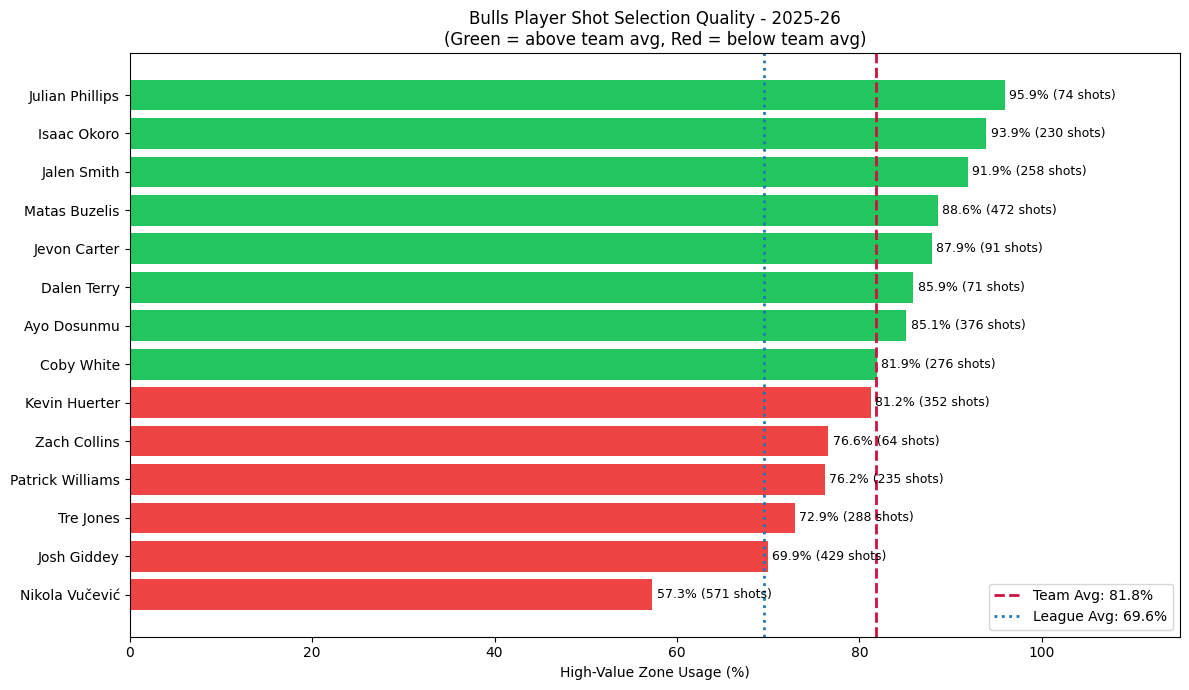

In [12]:
# Horizontal bar chart of player shot selection quality
fig, ax = plt.subplots(figsize=(12, max(6, len(player_df) * 0.5)))

# Sort by high-value %
player_sorted = player_df.sort_values('high_value_pct', ascending=True)

# Team average for reference
team_avg = player_df['high_value_pct'].mean()

# Color based on above/below team average
colors = ['#22c55e' if pct >= team_avg else '#ef4444' for pct in player_sorted['high_value_pct']]

bars = ax.barh(player_sorted['player_name'], player_sorted['high_value_pct'], color=colors)

# Add team average line
ax.axvline(x=team_avg, color='#CE1141', linestyle='--', 
           linewidth=2, label=f'Team Avg: {team_avg:.1f}%')

# Add league average line
ax.axvline(x=league_avg_high_value, color='#1f77b4', linestyle=':', 
           linewidth=2, label=f'League Avg: {league_avg_high_value:.1f}%')

# Add value labels
for bar, row in zip(bars, player_sorted.itertuples()):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f'{row.high_value_pct:.1f}% ({int(row.total_shots)} shots)',
            va='center', fontsize=9)

ax.set_xlabel('High-Value Zone Usage (%)')
ax.set_title(f'Bulls Player Shot Selection Quality - {CURRENT_SEASON}\n(Green = above team avg, Red = below team avg)')
ax.legend(loc='lower right')
ax.set_xlim(0, max(player_sorted['high_value_pct']) * 1.2)

plt.tight_layout()
plt.show()

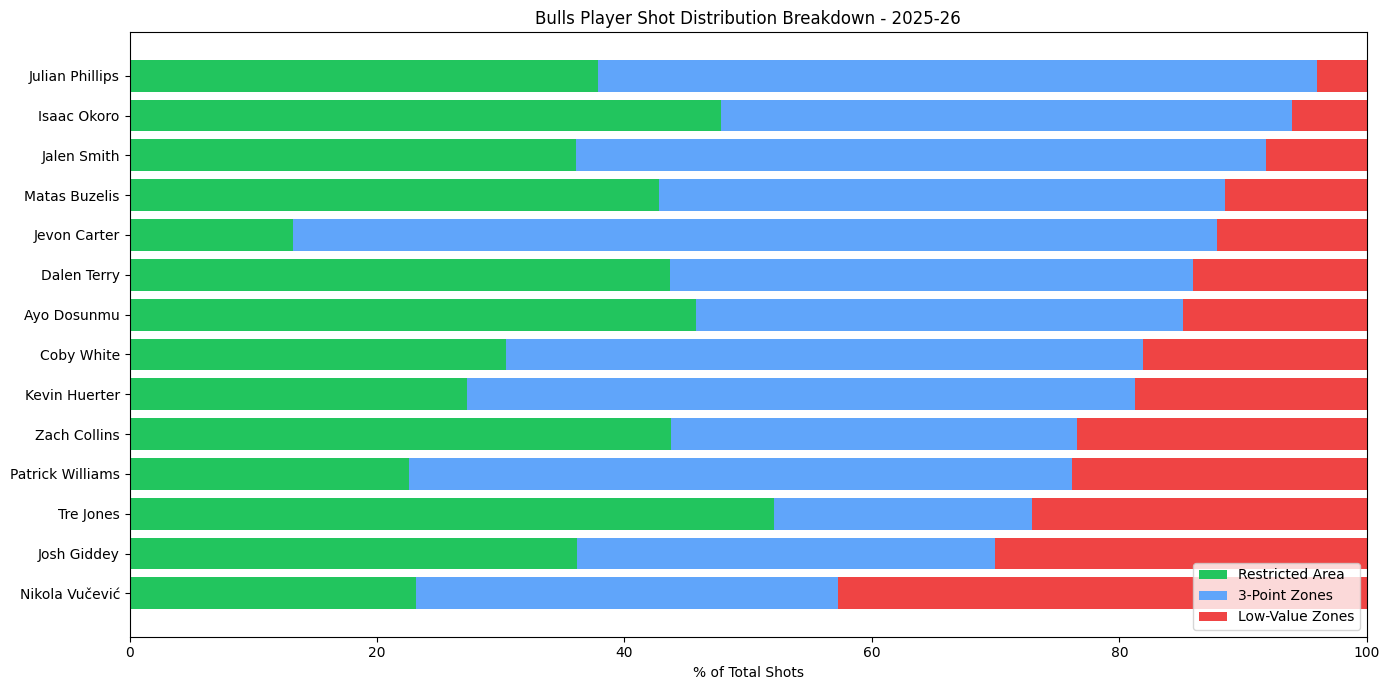

In [13]:
# Stacked bar chart showing shot distribution breakdown by player
fig, ax = plt.subplots(figsize=(14, max(6, len(player_df) * 0.5)))

# Sort by high-value %
player_sorted = player_df.sort_values('high_value_pct', ascending=True)

# Create stacked bars
players = player_sorted['player_name']
y_pos = np.arange(len(players))

# Stack: Restricted Area, 3PT zones, Low-value
restricted = player_sorted['restricted_pct'].values
three_pt = player_sorted['three_pt_pct'].values
low_value = player_sorted['low_value_pct'].values

ax.barh(y_pos, restricted, label='Restricted Area', color='#22c55e')
ax.barh(y_pos, three_pt, left=restricted, label='3-Point Zones', color='#60a5fa')
ax.barh(y_pos, low_value, left=restricted + three_pt, label='Low-Value Zones', color='#ef4444')

ax.set_yticks(y_pos)
ax.set_yticklabels(players)
ax.set_xlabel('% of Total Shots')
ax.set_title(f'Bulls Player Shot Distribution Breakdown - {CURRENT_SEASON}')
ax.legend(loc='lower right')
ax.set_xlim(0, 100)

plt.tight_layout()
plt.show()

---

## Section 6: Summary & Recommendations

In [14]:
# Executive Summary
print("=" * 70)
print(f"BULLS SHOT SELECTION ANALYSIS - {CURRENT_SEASON} SUMMARY")
print("=" * 70)

# Team Rankings
print(f"\n TEAM SHOT SELECTION RANKING")
print(f"   High-Value Zone Usage: {bulls_usage['high_value_pct']:.1f}%")
print(f"   League Rank: #{int(bulls_usage['rank'])} of 30 teams")
print(f"   vs League Average: {bulls_usage['high_value_pct'] - league_avg_high_value:+.1f}%")

# Shot Distribution Breakdown
print(f"\n SHOT DISTRIBUTION BREAKDOWN")
print(f"   Restricted Area: {bulls_usage['restricted_area_pct']:.1f}%")
print(f"   3-Point Zones:   {bulls_usage['three_point_pct']:.1f}%")
print(f"   Low-Value Zones: {bulls_usage['low_value_pct']:.1f}%")

# Gap Analysis
print(f"\n GAP ANALYSIS vs TOP 5 TEAMS")
gap = total_high_value_bulls - total_high_value_top5
if gap < 0:
    print(f"   Bulls are {abs(gap):.1f}% BEHIND top teams in high-value shot selection")
else:
    print(f"   Bulls are {gap:.1f}% AHEAD of top teams in high-value shot selection")

# Player Insights
print(f"\n PLAYER INSIGHTS")
if len(player_df) > 0:
    best_selector = player_df.iloc[0]
    worst_selector = player_df.iloc[-1]
    print(f"   Best Shot Selection:  {best_selector['player_name']} ({best_selector['high_value_pct']:.1f}%)")
    print(f"   Needs Improvement:    {worst_selector['player_name']} ({worst_selector['high_value_pct']:.1f}%)")

# Recommendations
print(f"\n RECOMMENDATIONS")
recommendations = []

if bulls_usage['restricted_area_pct'] < top5_distribution.get('Restricted Area', 0) - 2:
    recommendations.append("- Increase rim attacks and paint touches")
    
if bulls_usage['three_point_pct'] < sum(top5_distribution.get(z, 0) for z in ['Right Corner 3', 'Left Corner 3', 'Above the Break 3']) - 2:
    recommendations.append("- Generate more 3-point attempts, especially corner 3s")

mid_range_pct = bulls_distribution.get('Mid-Range', 0)
top5_mid_range = top5_distribution.get('Mid-Range', 0)
if mid_range_pct > top5_mid_range + 2:
    recommendations.append(f"- Reduce mid-range attempts ({mid_range_pct:.1f}% vs {top5_mid_range:.1f}% for top teams)")

if len(player_df) > 0:
    low_selection_players = player_df[player_df['high_value_pct'] < team_avg - 5]
    if len(low_selection_players) > 0:
        recommendations.append(f"- Work with {', '.join(low_selection_players['player_name'].tolist())} on shot selection")

if recommendations:
    for rec in recommendations:
        print(f"   {rec}")
else:
    print("   Shot selection is solid - focus on improving conversion rates.")

print("\n" + "=" * 70)

BULLS SHOT SELECTION ANALYSIS - 2025-26 SUMMARY

 TEAM SHOT SELECTION RANKING
   High-Value Zone Usage: 78.7%
   League Rank: #1 of 30 teams
   vs League Average: +9.1%

 SHOT DISTRIBUTION BREAKDOWN
   Restricted Area: 35.6%
   3-Point Zones:   43.2%
   Low-Value Zones: 21.3%

 GAP ANALYSIS vs TOP 5 TEAMS
   Bulls are 2.5% AHEAD of top teams in high-value shot selection

 PLAYER INSIGHTS
   Best Shot Selection:  Julian Phillips (95.9%)
   Needs Improvement:    Nikola Vučević (57.3%)

 RECOMMENDATIONS
   - Generate more 3-point attempts, especially corner 3s
   - Work with Zach Collins, Patrick Williams, Tre Jones, Josh Giddey, Nikola Vučević on shot selection



---

## Key Takeaways

### What We Measured
**Shot Selection Quality** - not who shoots best, but who shoots from the best locations.

### High-Value Zones (based on league PPS)
1. **Restricted Area** (~1.33 PPS) - The most valuable shot in basketball
2. **Corner 3s** (~1.15 PPS) - Most efficient 3-point shot
3. **Above the Break 3** (~1.05 PPS) - Still high value

### Low-Value Zones
1. **In The Paint (Non-RA)** (~0.89 PPS) - Contested floaters, short jumpers
2. **Mid-Range** (~0.83 PPS) - Lowest expected value per shot

### How to Use This Analysis
- **Coaching**: Emphasize shot selection in practice, design plays for high-value looks
- **Player Development**: Identify players who need shot selection coaching
- **Game Planning**: Create more opportunities for rim attacks and corner 3s
- **Analytics**: Track high-value zone usage game-to-game as a leading indicator